# Matching experiments in spiny

In [1]:

import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspologic.match import graph_match
from pkg.io import FIG_PATH, OUT_PATH
from pkg.data import DATA_PATH
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import set_theme
from scipy.io import mmread
from scipy.sparse import csr_array
from tqdm.autonotebook import tqdm
from git import Repo

DISPLAY_FIGS = True

FILENAME = "spiny_match_simple"

OUT_PATH = OUT_PATH / FILENAME

FIG_PATH = FIG_PATH / FILENAME


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


graspologic_path = "/Users/bpedigo/JHU_code/neuro-matching/graspologic"
graspologic_repo = Repo(graspologic_path)
print("Using new graph matching implementation under development, see PR:")
print("https://github.com/microsoft/graspologic/pull/960")
print(f"Current graspologic branch: {graspologic_repo.active_branch.name}")
print(f"Current graspologic commit hash: {graspologic_repo.head.commit}")

t0 = time.time()
set_theme()
rng = np.random.default_rng(888)
np.random.seed(8888)

Using new graph matching implementation under development, see PR:
https://github.com/microsoft/graspologic/pull/960
Current graspologic branch: new-gm
Current graspologic commit hash: 002597323787812190f7942b115f5e2f654f99b3


## Load the data

In [2]:
meta_loc = DATA_PATH / "spiny/meta_adj_spiny_big.csv"
meta = pd.read_csv(meta_loc, index_col=0)
meta["bodyid"] = meta["bodyid"].astype(int)
meta["group"] = meta["group"].astype("Int64")
meta = meta.set_index("bodyid")

adj_loc = DATA_PATH / "spiny/adj_spiny_big.mtx"
adj_dense = mmread(adj_loc).toarray()
adj_df = pd.DataFrame(data=adj_dense, index=meta.index, columns=meta.index)

## Selecting subsets of the data for some experiments

In [3]:


def select_paired_neuromere(meta, neuromere):
    # select the neuromere
    select_meta = meta[meta["soma_neuromere"].isin([neuromere])]

    # count occurences of "group"
    group_counts = select_meta["group"].value_counts()

    # find everything that occurs only twice
    single_group_counts = group_counts[group_counts == 2].index

    # subselect to these which are paired
    select_meta = select_meta[select_meta["group"].isin(single_group_counts)]
    select_meta = select_meta.sort_values("group")

    # split left right
    left_meta = select_meta[select_meta["soma_side"] == "LHS"]
    right_meta = select_meta[select_meta["soma_side"] == "RHS"]

    # grab subset for which we have on both left and right
    # because of filter above, these are the cases where we have one on right and left
    groups_in_both = np.intersect1d(left_meta["group"], right_meta["group"])
    left_meta = left_meta[left_meta["group"].isin(groups_in_both)]
    right_meta = right_meta[right_meta["group"].isin(groups_in_both)]

    # ensure indexed the same, useful assumption later
    assert left_meta["group"].values == right_meta["group"].values

    return left_meta, right_meta


def select_adjacency(source, target=None, sparse=False):
    if target is None:
        target = source
    sub_adjacency = adj_df.loc[source, target].values
    if sparse:
        sub_adjacency = csr_array(sub_adjacency)
    return sub_adjacency

In [4]:

# #%%
# from giskard.plot import adjplot

# adjplot(
#     ll_adj,
#     meta=left_meta,
#     sort_class=["class"],
#     plot_type="scattermap",
#     sizes=(0.5, 0.5),
# )

## Matching experiment
Here I do some simple matching experiments on 3 different segments. I compare
matching with/without using the contralateral connections, as well as with/without
the optimal transport modification to the algorithm.

For each experiment, I evaluate the matching accuracy (as well as collecting other
info like objective function value, timing, etc.). Because of this, here I am only
selecting the neurons for which there is already a pair prediction (i.e. only 2
neurons in the "group" field, and one on each hemisphere).

In [5]:

RERUN = False

n_seeds = 0
neuromeres = ["T1", "T2", "T3"]
sparse = True

if RERUN:
    rows = []
    with tqdm(total=2 * 2 * len(neuromeres)) as pbar:
        for neuromere in neuromeres:
            left_meta, right_meta = select_paired_neuromere(meta, neuromere)
            left_nodes = left_meta.index
            right_nodes = right_meta.index

            ll_adj = select_adjacency(left_nodes, left_nodes, sparse=sparse)
            rr_adj = select_adjacency(right_nodes, right_nodes, sparse=sparse)
            lr_adj = select_adjacency(left_nodes, right_nodes, sparse=sparse)
            rl_adj = select_adjacency(right_nodes, left_nodes, sparse=sparse)
            n = ll_adj.shape[0]

            print(f"Neuromere {neuromere} has {n} neurons per side.")

            perm = rng.permutation(n)
            undo_perm = np.argsort(perm)
            rr_adj = rr_adj[perm][:, perm]
            lr_adj = lr_adj[:, perm]
            rl_adj = rl_adj[perm]

            for transport in [False, True]:
                for bilateral in [False, True]:

                    pbar.update(1)

                    if bilateral:
                        AB = lr_adj
                        BA = rl_adj
                    else:
                        AB = None
                        BA = None

                    currtime = time.time()

                    indices_l, indices_r, score, misc = graph_match(
                        A=ll_adj,
                        B=rr_adj,
                        AB=AB,
                        BA=BA,
                        transport=transport,
                        transport_regularizer=700,
                        rng=rng.integers(np.iinfo(np.uint32).max),
                        max_iter=60,
                    )
                    match_ratio_full = (indices_r == undo_perm).mean()
                    elapsed = time.time() - currtime

                    result = {
                        "match_ratio_full": match_ratio_full,
                        "n_seeds": n_seeds,
                        "elapsed": elapsed,
                        "bilateral": bilateral,
                        "transport": transport,
                        "n_iter": misc[0]["n_iter"],
                        "converged": misc[0]["converged"],
                        "n": n,
                        "neuromere": neuromere,
                        "score": score,
                    }
                    rows.append(result)
    results = pd.DataFrame(rows)
    results.to_csv(OUT_PATH / "simple_matching_summary.csv")
else:
    results = pd.read_csv(OUT_PATH / "simple_matching_summary.csv", index_col=0)

results

,match_ratio_full,n_seeds,elapsed,bilateral,transport,n_iter,converged,n,neuromere,score
0,0.872142,0,14.260143,False,False,21,True,1181,T1,39545039.0
1,0.894157,0,7.693665,True,False,8,True,1181,T1,64921595.0
2,0.753599,0,10.804721,False,True,8,True,1181,T1,38999288.0
3,0.861981,0,10.398010,True,True,7,True,1181,T1,64928921.0
4,0.815504,0,17.188315,False,False,19,True,1290,T2,53049263.0
5,0.909302,0,17.192980,True,False,10,True,1290,T2,90072795.0
6,0.831008,0,30.666001,False,True,14,True,1290,T2,55804237.0
7,0.894574,0,14.265408,True,True,7,True,1290,T2,89986867.0
8,0.812081,0,13.314117,False,False,22,True,1043,T3,33363038.0
9,0.900288,0,6.489409,True,False,7,True,1043,T3,58946480.0


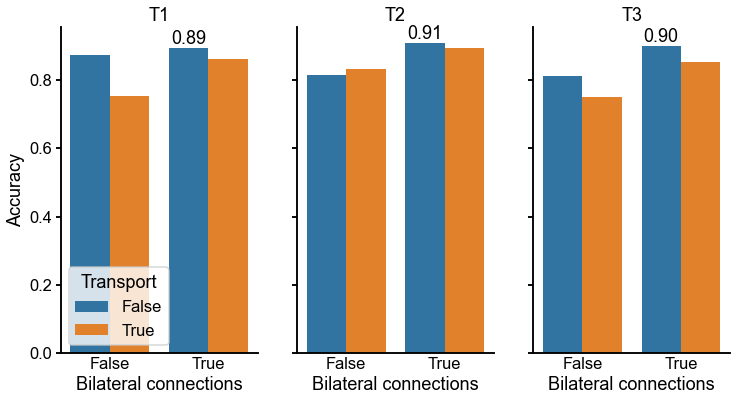

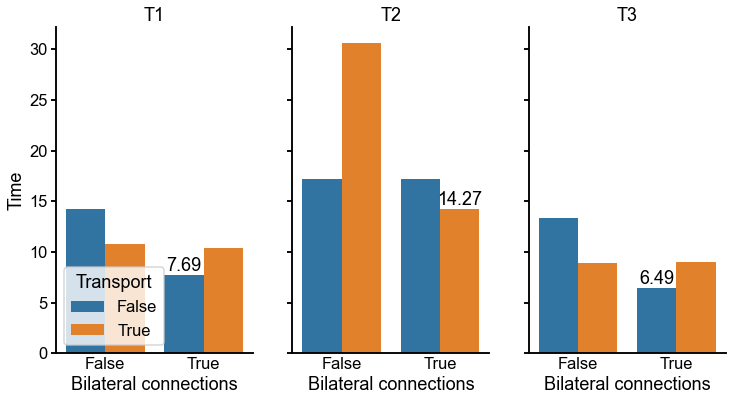

In [6]:


def plot_results_by_neuromere(y_var, name, maximize=True):
    fig, axs = plt.subplots(
        1, len(neuromeres), figsize=(4 * len(neuromeres), 6), sharey=True, squeeze=False
    )
    for i, neuromere in enumerate(neuromeres):
        neuromere_results = results[results["neuromere"] == neuromere]
        ax = axs[0][i]
        sns.barplot(
            data=neuromere_results,
            x="bilateral",
            hue="transport",
            y=y_var,
            ax=ax,
        )
        ax.set_ylabel("")
        if i != 0:
            ax.get_legend().remove()
        ax.set_xlabel("Bilateral connections")
        ax.set_title(neuromere)
        if maximize:
            best_idx = neuromere_results[y_var].idxmax()
        else:
            best_idx = neuromere_results[y_var].idxmin()
        best_row = neuromere_results.loc[best_idx].copy()
        x = int(best_row["bilateral"])
        x = x + 0.4 * float(best_row["transport"]) - 0.2
        y = best_row[y_var]
        ax.text(x, y, f"{y:.2f}", ha="center", va="bottom")
        ax.tick_params(axis="y", length=5)

    axs[0, 0].set_ylabel(name)
    sns.move_legend(axs[0, 0], loc="lower left", frameon=True, title="Transport")


plot_results_by_neuromere("match_ratio_full", "Accuracy")
plot_results_by_neuromere("elapsed", "Time", maximize=False)

## Takeaways
- I think the matching accuracy is surprisingly good given that we are using no seeds
  here for any of these methods?
- It seems like using the contralateral connections consistently gives slightly better
  results. Note that it tends to be faster, too, which is interesting given that there
  are twice as many matrix multiplies per iteration!
- It appears that using the "transport" option here is not helpful for most cases.

## Next steps
- I want to make sure that what I'm doing here seems like a fair evaluation, at least
  for this subset of the data?
- I'd like to look into whether incorrect matches are matching outside of their class
  or hemilineage. If not, then the extra constraints/priors from including that info
  likely will not help very much.
- Could look at how this improves when adding seeds.

In [7]:
# #%% [markdown]
# # ## Look at similarity

# rng = np.random.default_rng(8888)
# n_seeds = 0
# neuromeres = ["T1", "T2", "T3"]
# sparse = True
# label_var = "class"
# similarity_weights = [0] + list(np.geomspace(0.01, 1000, 5))
# rows = []
# with tqdm(total=1 * 1 * len(neuromeres) * len(similarity_weights)) as pbar:
#     for neuromere in neuromeres:
#         left_meta, right_meta = select_paired_neuromere(meta, neuromere)
#         left_nodes = left_meta.index
#         right_nodes = right_meta.index

#         ll_adj = select_adjacency(left_nodes, left_nodes, sparse=sparse)
#         rr_adj = select_adjacency(right_nodes, right_nodes, sparse=sparse)
#         lr_adj = select_adjacency(left_nodes, right_nodes, sparse=sparse)
#         rl_adj = select_adjacency(right_nodes, left_nodes, sparse=sparse)
#         n = ll_adj.shape[0]

#         print(f"Neuromere {neuromere} has {n} neurons per side.")

#         perm = rng.permutation(n)
#         undo_perm = np.argsort(perm)
#         rr_adj = rr_adj[perm][:, perm]
#         lr_adj = lr_adj[:, perm]
#         rl_adj = rl_adj[perm]

#         left_labels = left_meta[label_var].values
#         right_labels = right_meta[label_var].values

#         for similarity_weight in similarity_weights:
#             S = similarity_weight * (
#                 left_labels[:, None] == right_labels[None, :]
#             ).astype(float)

#             for transport in [False]:
#                 for bilateral in [True]:

#                     pbar.update(1)

#                     if bilateral:
#                         AB = lr_adj
#                         BA = rl_adj
#                     else:
#                         AB = None
#                         BA = None

#                     currtime = time.time()

#                     indices_l, indices_r, score, misc = graph_match(
#                         A=ll_adj,
#                         B=rr_adj,
#                         AB=AB,
#                         BA=BA,
#                         S=S,
#                         transport=transport,
#                         transport_regularizer=700,
#                         rng=rng.integers(np.iinfo(np.uint32).max),
#                         max_iter=60,
#                         n_init=10,
#                         n_jobs=-2,
#                     )
#                     match_ratio_full = (indices_r == undo_perm).mean()
#                     elapsed = time.time() - currtime

#                     result = {
#                         "match_ratio_full": match_ratio_full,
#                         "n_seeds": n_seeds,
#                         "elapsed": elapsed,
#                         "bilateral": bilateral,
#                         "transport": transport,
#                         "n_iter": misc[0]["n_iter"],  # TODO fix
#                         "converged": misc[0]["converged"],  # TODO fix
#                         "n": n,
#                         "neuromere": neuromere,
#                         "score": score,
#                         "similarity_weight": similarity_weight,
#                     }
#                     rows.append(result)


# #%%
# results = pd.DataFrame(rows)
# results

# #%%
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# sns.lineplot(data=results, x="similarity_weight", y="match_ratio_full", ax=ax)

## %%